In [46]:
# Parameters to set to run this notebook

# Initialize helpers.
import numpy as np
import project_path
from model.data_accessor import get_data_file_abs_path
from model.neuron_metadata import *
neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json(get_data_file_abs_path('chem.json'))
N = neuron_metadata_collection.get_size()

# How many seconds to run each step for. This should be long enough for stability to be observed.
step_duration_s = 2
# The step amplitudes in nA. Each amplitude will be run for step_duration
peak = 2.0
amp_delta = 0.1
step_amplitudes_nA = np.concatenate((np.arange(0, peak, amp_delta), \
                                     np.arange(peak, -amp_delta/2, -amp_delta)), axis=None) 

# Initial condition
# If you want a fixed-seed initial condition, uncomment the line below.
# np.random.seed(0)
init_conds = 10**(-4)*np.random.normal(0, 0.94, 2*N)

In [47]:
from model.neural_model import NeuralModel
from util.plot_util import *

model = NeuralModel(neuron_metadata_collection)
model.init_conds = init_conds

# Set I_inj_i(t)
awal_index = neuron_metadata_collection.get_id_from_name("AWAL")
awar_index = neuron_metadata_collection.get_id_from_name("AWAR")

def time_to_I_ext_fun(t):
  amp = step_amplitudes_nA[int(t / step_duration_s)]
  cur_I_ext = np.zeros(N)
  cur_I_ext[awal_index] = amp
  cur_I_ext[awar_index] = amp
  return cur_I_ext

# These are timesteps when I_ext changes
num_step_values = len(step_amplitudes_nA)
t_changes_I_ext = np.array(range(num_step_values)) * step_duration_s
t_changes_I_ext = t_changes_I_ext.tolist()
model.set_I_ext(time_to_I_ext_fun, t_changes_I_ext)

model.init_kunert_2017()

step_duration_timesteps = int(step_duration_s / model.dt)
simul_timesteps = step_duration_timesteps * len(step_amplitudes_nA)
(v_mat, s_mat, v_normalized_mat) = model.run(simul_timesteps)

# The oscillatory dynamic doesn't stabilize until about dt*300 onwards.
# Also, interactome analysis is done after the first 50 timesteps.
truncated_potentials = v_normalized_mat[:,:]

Timestep 0 out of 8200
Timestep 100 out of 8200
Timestep 200 out of 8200
Timestep 300 out of 8200
Timestep 400 out of 8200
Timestep 500 out of 8200
Timestep 600 out of 8200
Timestep 700 out of 8200
Timestep 800 out of 8200
Timestep 900 out of 8200
Timestep 1000 out of 8200
Timestep 1100 out of 8200
Timestep 1200 out of 8200
Timestep 1300 out of 8200
Timestep 1400 out of 8200
Timestep 1500 out of 8200
Timestep 1600 out of 8200
Timestep 1700 out of 8200
Timestep 1800 out of 8200
Timestep 1900 out of 8200
Timestep 2000 out of 8200
Timestep 2100 out of 8200
Timestep 2200 out of 8200
Timestep 2300 out of 8200
Timestep 2400 out of 8200
Timestep 2500 out of 8200
Timestep 2600 out of 8200
Timestep 2700 out of 8200
Timestep 2800 out of 8200
Timestep 2900 out of 8200
Timestep 3000 out of 8200
Timestep 3100 out of 8200
Timestep 3200 out of 8200
Timestep 3300 out of 8200
Timestep 3400 out of 8200
Timestep 3500 out of 8200
Timestep 3600 out of 8200
Timestep 3700 out of 8200
Timestep 3800 out of 820

# Plot potentials of selected neurons

/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


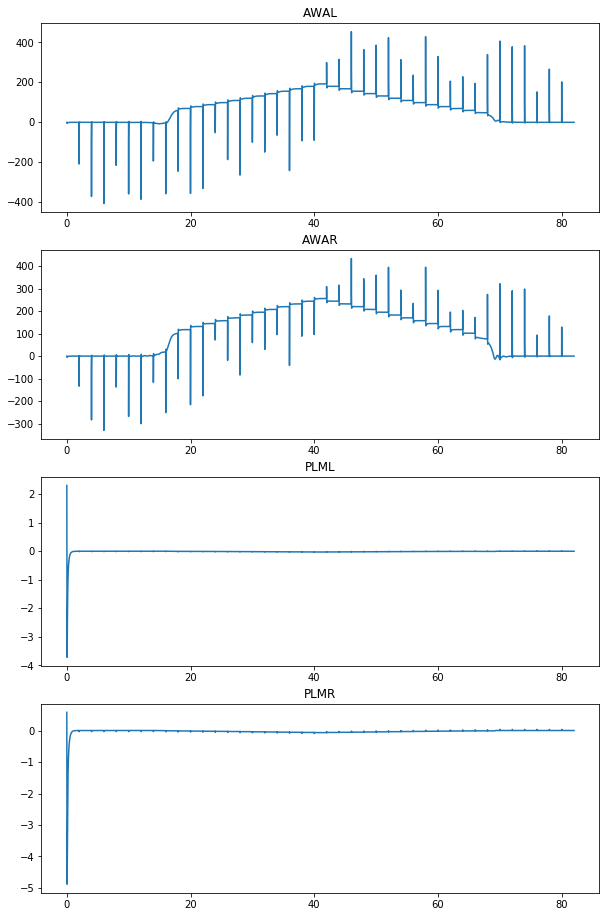

In [48]:
fig = plot_potentials(neurons_to_observe, truncated_potentials, model.dt, neuron_metadata_collection)
fig.show()

# Plot summarized dynamics per neuron class

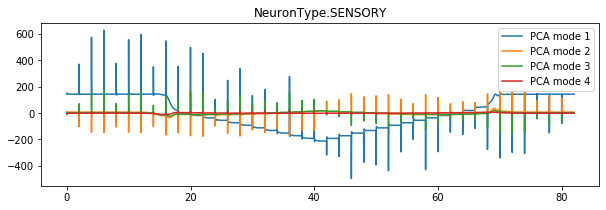

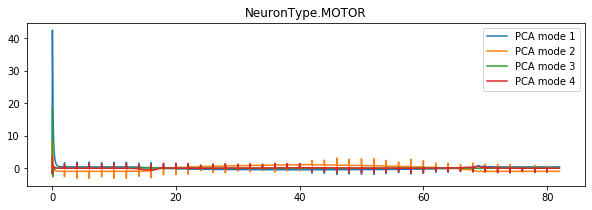

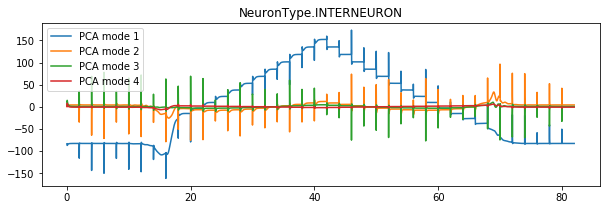

In [49]:
plot_pcas(truncated_potentials, model.dt, neuron_metadata_collection)